In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, pearsonr

import os
import time
import itertools

from glove.model import *

In [2]:
# import file names
files = os.listdir("data/")
strains = ["DSM"]

In [3]:
def predict_df(df, species):
    
    # save measured and predicted values
    exp_names = []
    pred_species = []
    pred = []
    stdv = []
    true = []

    # pull just the community data
    test_data = process_df(df, species) 

    # plot the results
    for exp, t_span, Y_m in test_data:

        # predict 
        Y_p, Y_std = model.predict(Y_m, t_span)
        
        # set NaN to zero
        Y_p = np.nan_to_num(Y_p)
        Y_std = np.nan_to_num(Y_std)
        
        ### prediction results for species that were present ###
        inds_present = Y_m[0] > 0 
        exp_names.append([exp]*sum(inds_present)*(Y_m.shape[0]-1))
        pred_species.append(np.tile(np.vstack(species)[inds_present], Y_m.shape[0]-1).T.ravel())
        true.append(Y_m[1:,inds_present].ravel())
        pred.append(Y_p[1:,inds_present].ravel())
        stdv.append(Y_std[1:,inds_present].ravel())
                
    # concatenate list
    exp_names = np.concatenate(exp_names)
    pred_species = np.concatenate(pred_species)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    stdv = np.concatenate(stdv)
        
    return exp_names, pred_species, true, pred, stdv

# fit gLV models

In [4]:
exp_names = []
for strain in strains:
    # import data
    df_universal = pd.read_csv("data/Universal.csv")
    df_strain = pd.concat([pd.read_csv(f"data/{fname}") for fname in files if strain in fname])
    df = pd.concat((df_universal, df_strain))
    df.sort_values(by=["Treatments", "Time"], inplace=True)

    # determine species names 
    species = df.columns.values[2:]

    # instantiate gLV fit 
    model = gLV(species, df)

    # fit to data 
    model.fit()
    
    # list of parameter names 
    exp_names, pred_species, true, pred, stdv = predict_df(df, species)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Total samples: 90, Initial regularization: 1.00e-03
Loss: 16.472, Residuals: 0.028
Loss: 10.842, Residuals: -0.052
Loss: 9.298, Residuals: 0.109
Loss: 7.837, Residuals: -0.036
Loss: 7.429, Residuals: 0.091
Loss: 6.867, Residuals: 0.066
Loss: 6.565, Residuals: 0.020
Loss: 6.516, Residuals: 0.027
Loss: 6.434, Residuals: 0.016
Loss: 6.399, Residuals: 0.016
Loss: 6.340, Residuals: 0.007
Loss: 6.259, Residuals: -0.011
Loss: 6.251, Residuals: 0.001
Loss: 6.237, Residuals: -0.000
Loss: 6.211, Residuals: -0.004
Loss: 6.201, Residuals: -0.001
Loss: 6.183, Residuals: -0.004
Loss: 6.174, Residuals: -0.003
Loss: 6.159, Residuals: -0.007
Loss: 6.157, Residuals: -0.006
Loss: 6.154, Residuals: -0.007
Loss: 6.149, Residuals: -0.009
Loss: 6.142, Residuals: -0.014
Loss: 6.141, Residuals: -0.014
Loss: 6.140, Residuals: -0.014
Loss: 6.139, Residuals: -0.016
Loss: 6.137, Residuals: -0.019
Loss: 6.137, Residuals: -0.019
Loss: 6.136, Residuals: -0.019
Loss: 6.136, Residuals: -0.019
Loss: 6.136, Residuals: -0

In [6]:
ch_inds = pred_species == 'CH'
measured_values = true[ch_inds]
predicted_values = pred[ch_inds]
predicted_errors = stdv[ch_inds]

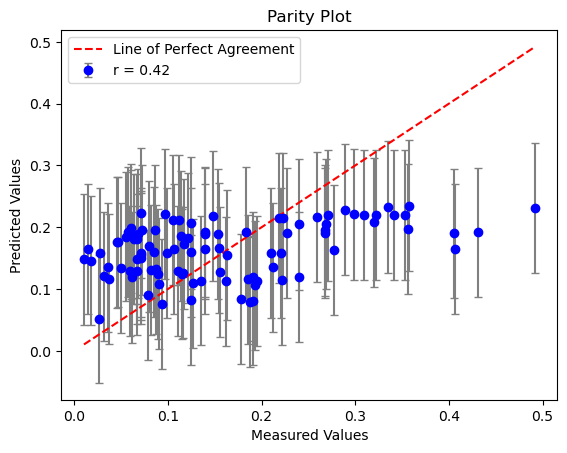

In [12]:
# Plot the parity plot
plt.errorbar(measured_values, predicted_values, yerr=predicted_errors,
             fmt='o', color='blue', ecolor='gray', capsize=3)

# Add line of perfect agreement
plt.plot([min(measured_values), max(measured_values)],
         [min(measured_values), max(measured_values)],
         linestyle='--', color='red')

# Calculate Pearson correlation coefficient
correlation, _ = pearsonr(measured_values, predicted_values)

# Add legend with Pearson correlation coefficient
plt.legend(['Line of Perfect Agreement', f'r = {correlation:.2f}'],
           loc='upper left')

# Set labels and title
plt.xlabel('Measured Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')

# Set plot limits
#plt.xlim(min(measured_values), max(measured_values))
#plt.ylim(min(predicted_values), max(predicted_values))

# Show the plot
plt.savefig("figures/DSM_CH_fit.pdf")
plt.show()